# **Klasifikasi Tingkat Kematangan Buah Pisang Menggunakan Convolutional Neural Network (CNN)**

## **Objective:**   
mengembangkan model deep learning berbasis Convolutional Neural Network (CNN) guna mengklasifikasikan tingkat kematangan buah pisang ke dalam empat kategori: *unripe*, *ripe*, *overripe*, dan *rotten*.

Keterangan:
1. Unripe → Mentah
2. Ripe → Matang
3. Overripe → Terlalu Matang
4. Rotten → Busuk

## **Sumber Dataset**
https://www.kaggle.com/datasets/atrithakar/banana-classification

## **Import Libraries**

In [ ]:
# Import modules & Set SEED
import os
import gdown
import zipfile
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## **Data Loading**

In [ ]:
# Download dari Google Drive
file_id = "1oL0-ehm1l6Vmgv3IXZGQf44OJ0D-tS6C"
output_zip = "banana_dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_zip, quiet=False)

# Ekstrak zip ke folder
extract_dir = "banana_dataset"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Dataset berhasil diunduh dan diekstrak.")

Downloading...
From (original): https://drive.google.com/uc?id=1oL0-ehm1l6Vmgv3IXZGQf44OJ0D-tS6C
From (redirected): https://drive.google.com/uc?id=1oL0-ehm1l6Vmgv3IXZGQf44OJ0D-tS6C&confirm=t&uuid=a907f6a2-e69a-4640-a8c0-50234f6cf65e
To: /content/banana_dataset.zip
100%|██████████| 228M/228M [00:04<00:00, 53.7MB/s]


✅ Dataset berhasil diunduh dan diekstrak.


### **Plot gambar sampel untuk semua kelas**

Kelas ditemukan: ['overripe', 'ripe', 'rotten', 'unripe']


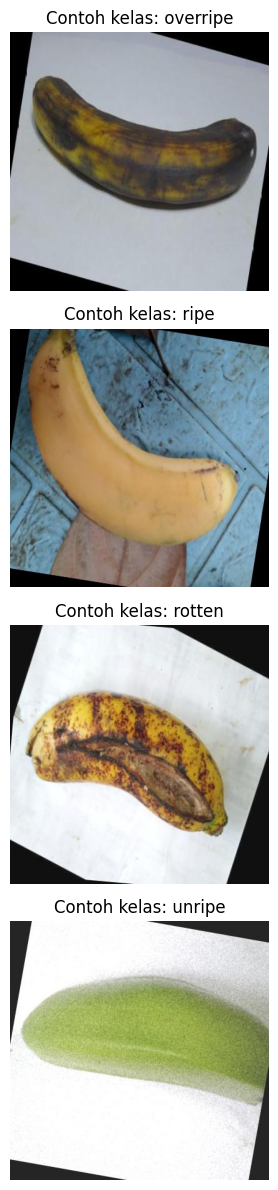

In [ ]:

# Path dataset
dataset_path = "banana_dataset/banana_dataset"

# Ambil nama kelas
classes = sorted(os.listdir(dataset_path))
print(f"Kelas ditemukan: {classes}")

# Tampilkan 1 gambar acak dari setiap kelas
plt.figure(figsize=(8, 3 * len(classes)))

for idx, label in enumerate(classes):
    class_folder = os.path.join(dataset_path, label)
    img_files = os.listdir(class_folder)

    if img_files:
        img_path = os.path.join(class_folder, random.choice(img_files))
        img = Image.open(img_path)

        plt.subplot(len(classes), 1, idx + 1)
        plt.imshow(img)
        plt.title(f"Contoh kelas: {label}")
        plt.axis('off')

plt.tight_layout()
plt.show()

### **Plot distribusi gambar di seluruh kelas**

/tmp/ipython-input-2896508188.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


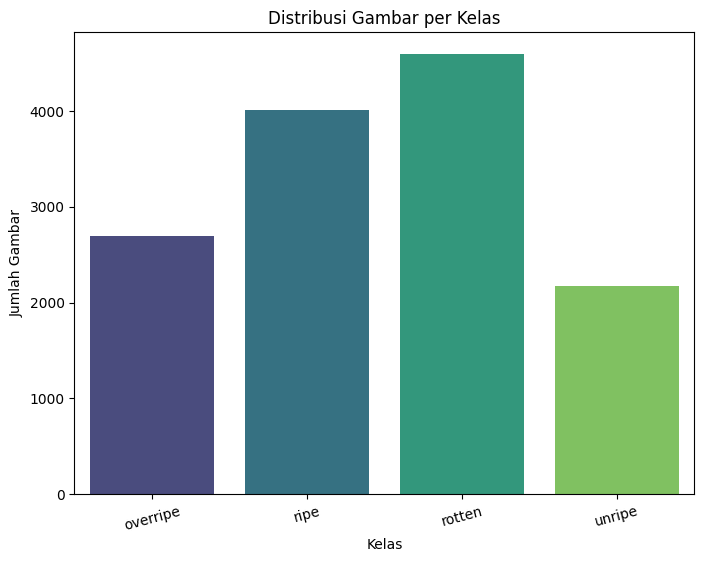

In [ ]:
# Hitung jumlah gambar di setiap kelas
class_counts = {
    label: len(os.listdir(os.path.join(dataset_path, label)))
    for label in classes
}

# Visualisasi
plt.figure(figsize=(8, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=15)
plt.show()

## **Data Splitting : Training, Validation, and Testing**

In [ ]:
dataset_path = "banana_dataset/banana_dataset"
classes = sorted(os.listdir(dataset_path))

image_paths = []
image_labels = []

# Loop melalui setiap kelas untuk mengambil gambar
for label in classes:
    class_folder = os.path.join(dataset_path, label)
    img_files = os.listdir(class_folder)

    for img_file in img_files:
        image_paths.append(os.path.join(class_folder, img_file))
        image_labels.append(label)  # Label sesuai nama folder

# Cetak jumlah total gambar yang ditemukan
print(f"Total gambar ditemukan: {len(image_paths)}")

Total gambar ditemukan: 13478


In [ ]:

from sklearn.model_selection import train_test_split

# Split Train (80%) dan Sisa data (20%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, image_labels,
    test_size=0.2,
    random_state=SEED,
    stratify=image_labels
)

# Dari sisa 20% → split menjadi validasi (10%) dan testing (10%)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.5,
    random_state=SEED,
    stratify=temp_labels
)

print("Total data:", len(image_paths))
print("Train:", len(train_paths))
print("Validation:", len(val_paths))
print("Test:", len(test_paths))

Total data: 13478
Train: 10782
Validation: 1348
Test: 1348


## **Data Preparation**

In [ ]:

# Parameter
IMG_SIZE = 224
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Buat mapping label string ke angka
classes = sorted(set(train_labels + val_labels + test_labels))
label_to_index = {label: idx for idx, label in enumerate(classes)}

# Ubah label string ke angka
train_labels_idx = [label_to_index[label] for label in train_labels]
val_labels_idx = [label_to_index[label] for label in val_labels]
test_labels_idx = [label_to_index[label] for label in test_labels]

# Konversi ke tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_idx))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels_idx))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels_idx))

# Fungsi preprocessing
def preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

train_ds = (
    train_ds
    .map(preprocess_image)
    .shuffle(500)
    .batch(BATCH_SIZE)
    .prefetch(1)
)

val_ds = (
    val_ds
    .map(preprocess_image)
    .batch(BATCH_SIZE)
    .prefetch(1)
)

test_ds = (
    test_ds
    .map(preprocess_image)
    .batch(BATCH_SIZE)
    .prefetch(1)
)

# Cek info
print(f"Classes: {label_to_index}")
print(f"Total train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")

Classes: {'overripe': 0, 'ripe': 1, 'rotten': 2, 'unripe': 3}
Total train: 10782, val: 1348, test: 1348


## **Model CNN**


In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer, Conv2D, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
)

tf.keras.backend.clear_session()

# Ukuran gambar
IMG_SIZE = 160

class_names = ["overripe", "ripe", "rotten", "unripe"]

print("Total Classes:", len(class_names))
print("Classes:", class_names)

model_2 = Sequential([
    InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3), name="input_layer"),

    # Conv block 1
    Conv2D(32, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Conv block 2
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Conv block 3
    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.4),

    Dense(len(class_names), activation='softmax', name="output_layer")
])

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

Total Classes: 4
Classes: ['overripe', 'ripe', 'rotten', 'unripe']


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,172 (434.27 KB)

 Trainable params: 110,724 (432.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:

from tensorflow.keras.callbacks import EarlyStopping

# Early stopping lebih agresif
early_stopping_2 = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# Training model
history_2 = model_2.fit(
    train_ds,
    epochs=3,
    validation_data=val_ds,
    callbacks=[early_stopping_2],
    verbose=1
)

Epoch 1/3
674/674 ━━━━━━━━━━━━━━━━━━━━ 903s 1s/step - accuracy: 0.6746 - loss: 0.8105 - val_accuracy: 0.8694 - val_loss: 0.3849
Epoch 2/3
674/674 ━━━━━━━━━━━━━━━━━━━━ 900s 1s/step - accuracy: 0.8654 - loss: 0.3898 - val_accuracy: 0.9169 - val_loss: 0.2637
Epoch 3/3
674/674 ━━━━━━━━━━━━━━━━━━━━ 909s 1s/step - accuracy: 0.8852 - loss: 0.3244 - val_accuracy: 0.8457 - val_loss: 0.3511
Restoring model weights from the end of the best epoch: 2.


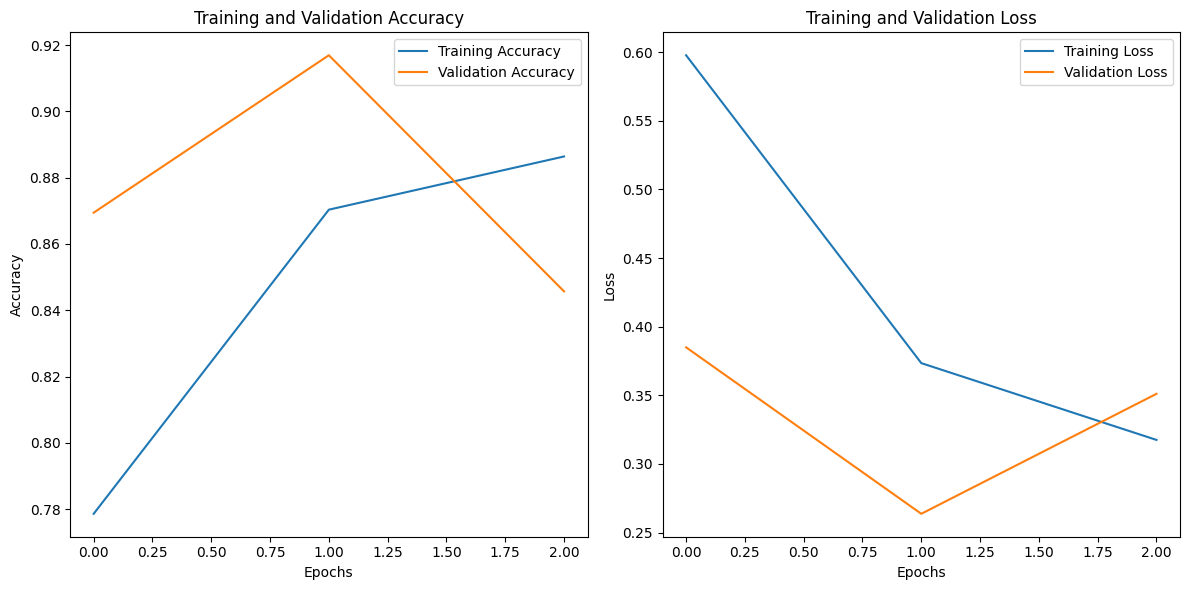

In [ ]:
# Plotting Akurasi dan Loss
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Evolution**

Accuracy: 0.9117
F1-score (Macro Average): 0.9150
F1-score (Micro Average): 0.9117
F1-score (Weighted Average): 0.9118


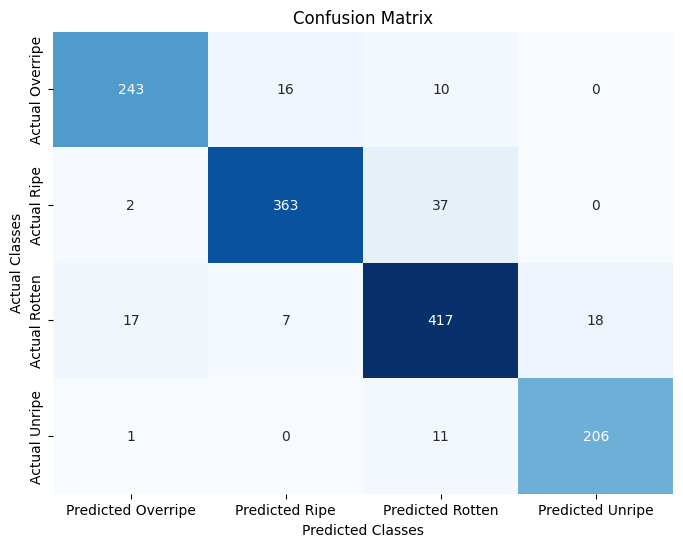


Classification Report:
              precision    recall  f1-score   support

    Overripe     0.9240    0.9033    0.9135       269
        Ripe     0.9404    0.9030    0.9213       402
      Rotten     0.8779    0.9085    0.8929       459
      Unripe     0.9196    0.9450    0.9321       218

    accuracy                         0.9117      1348
   macro avg     0.9155    0.9149    0.9150      1348
weighted avg     0.9125    0.9117    0.9118      1348



In [ ]:
# Menghitung prediksi untuk data testing
preds_2 = model_2.predict(test_ds, verbose=0)

# Prediksi kelas dengan probabilitas tertinggi
predicted_classes_2 = tf.argmax(preds_2, axis=-1).numpy()

# Menghitung akurasi
accuracy_2 = accuracy_score(test_labels_idx, predicted_classes_2)
print(f"Accuracy: {accuracy_2:.4f}")

# Menghitung F1-score untuk setiap kelas dan rata-rata (macro, micro, weighted)
f1_macro_2 = f1_score(test_labels_idx, predicted_classes_2, average='macro')
f1_micro_2 = f1_score(test_labels_idx, predicted_classes_2, average='micro')
f1_weighted_2 = f1_score(test_labels_idx, predicted_classes_2, average='weighted')

print(f"F1-score (Macro Average): {f1_macro_2:.4f}")_
print(f"F1-score (Micro Average): {f1_micro_2:.4f}")
print(f"F1-score (Weighted Average): {f1_weighted_2:.4f}")

# Confusion Matrix
cm_2 = confusion_matrix(test_labels_idx, predicted_classes_2, labels=[0, 1, 2, 3])
cm_df_2 = pd.DataFrame(cm_2, index=["Actual Overripe", "Actual Ripe", "Actual Rotten", "Actual Unripe"],
                     columns=["Predicted Overripe", "Predicted Ripe", "Predicted Rotten", "Predicted Unripe"])

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df_2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels_idx, predicted_classes_2, target_names=['Overripe', 'Ripe', 'Rotten', 'Unripe'], digits=4))

## **Save Model**

In [ ]:
# SIMPAN MODEL KE H5
model_2.save("banana_model_final.h5")

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()
with open('banana_model.tflite', 'wb') as f:
    f.write(tflite_model)
print('✔ Converted to TFLite!')

Saved artifact at '/tmp/tmp05s2e5ft'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138205597550160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138205597549776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138205599168464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138205599166160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138205599170000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138205597549584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138208376833232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138205597551312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138205599167312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138205599167120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138205599164816

In [ ]:
# Install TensorFlow.js converter
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.12.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.


In [ ]:
import tensorflow as tf
import tensorflowjs as tfjs

model = tf.keras.models.load_model("banana_model_final.h5")
tfjs.converters.save_keras_model(model, "tfjs_model")

print("✅ Model TFJS berhasil dibuat")

failed to lookup keras version from the file,
    this is likely a weight only file
✅ Model TFJS berhasil dibuat


In [ ]:
!zip -r tfjs_model.zip tfjs_model

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard1of1.bin (deflated 8%)
  adding: tfjs_model/model.json (deflated 88%)


In [ ]:
from google.colab import files
files.download("tfjs_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("banana_model_final.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("banana_model_final.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpoahv1xln'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135688417247056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135688415806096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135688415806864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135688415808400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135688415807632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135688415807248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135688415806672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135688415807056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135688415809552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135688415809936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135688415809360

## **Inference Data Baru**

Saving 854849.webp to 854849.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


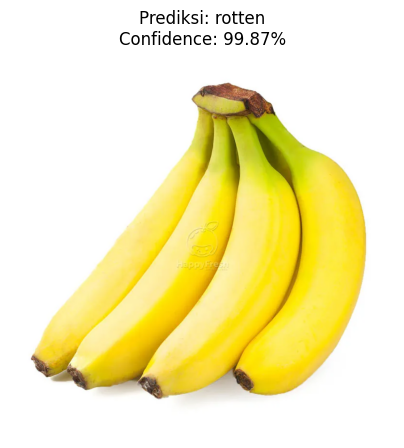

✅ Prediksi: rotten (99.87% confidence)


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt

# Parameter
IMG_SIZE = 224
LABELS = ['overripe', 'ripe', 'rotten', 'unripe']

# ✅ Load Model dari H5 (BENAR)
model = tf.keras.models.load_model("best_model.h5")

# Upload Gambar Pisang
uploaded = files.upload()
file_name = list(uploaded.keys())[0]

# Preprocess Gambar
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((IMG_SIZE, IMG_SIZE))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    return image.astype(np.float32)

# Fungsi Inference
def predict_image(image_path):
    image = load_and_preprocess_image(image_path)
    predictions = model.predict(image)
    predicted_class = LABELS[np.argmax(predictions)]
    confidence = np.max(predictions)
    return predicted_class, confidence

# Prediksi
predicted_class, confidence = predict_image(file_name)

# Tampilkan hasil
plt.figure(figsize=(5, 5))
img = Image.open(file_name)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence*100:.2f}%")
plt.show()

print(f"✅ Prediksi: {predicted_class} ({confidence*100:.2f}% confidence)")